In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import scipy.stats
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from GeneTEA.utils import clean_word_tokenize, tril_stack, read_gmt, download_to_cache_ext
from GeneTEA.eval.benchmarking_tests import find_coeffs, get_overlaps
from GeneTEA.eval.plotting import *
from GeneTEA.train import load_models
from GeneTEA.utils import GeneSymbolMapper
tea = load_models("../trained_models", name="GeneTEA")
gsm = GeneSymbolMapper()

# Replace paths below

Note: download_to_cache_ext is a wrapper function to get a local filepath.

In [3]:
v=24
FILEPATHS = {
    "hgnc_mapping":download_to_cache_ext(f"genetea-manuscript-bb10.{v}/hgnc_complete_set_2024-01-01", ext="txt"),
    "mrconso":download_to_cache_ext(f"genetea-manuscript-bb10.{v}/MRCONSO", ".txt"),
    "enrichr_sets":download_to_cache_ext(f"genetea-manuscript-bb10.{v}/enrichr_sets_03_01_2025", ".csv"),
    "ggost_sets":download_to_cache_ext(f"genetea-manuscript-bb10.{v}/gprofiler_full_hsapiens.name", ".gmt"),
    "enrichr_connexin":download_to_cache_ext(f"genetea-manuscript-bb10.{v}/gene sets for connexin", ".gmt")
}

[##################]100% |  33.2 MiB/s | 127.8 MiB / 127.8 MiB | Time:  0:00:03


In [4]:
hgnc_mapping = pd.read_csv(FILEPATHS["hgnc_mapping"], low_memory=False, sep="\t")
protein_coding = hgnc_mapping.loc[
    (hgnc_mapping["locus_group"] == "protein-coding gene") & hgnc_mapping["symbol"].isin(tea.entities), "symbol"
]
hgnc_groups = hgnc_mapping.set_index("symbol").loc[protein_coding, "gene_group"].str.split("|").explode()
hgnc_groups = hgnc_groups.groupby(hgnc_groups).apply(lambda x: list(x.index)).loc[lambda x: x.apply(len) > 1]

# GeneTEA synonyms vs. UMLS

In [5]:
mrconso = pd.read_csv(
    FILEPATHS["mrconso"], sep='|', encoding='utf-8',
    names=[
        "CUI", "LAT", "TS", "LUI", "STT", "SUI", "ISPREF", "AUI", "SAUI", "SCUI",
        "SDUI", "SAB", "TTY", "CODE", "STR", "SRL", "SUPPRESS", "CVF", "filler"
    ],
    header=None, low_memory=False
)
#get terms in english that are part of multiple vocabs
mrconso = mrconso.loc[lambda x: (x["LAT"] == "ENG")]
#clean the strings into tokens
mrconso["clean_str"] = mrconso["STR"].dropna().apply(
    lambda x: " ".join(clean_word_tokenize(x, remove_punct=True))
)
#identify overlaps with mrconso
mrconso_filt = mrconso.loc[lambda x: x["clean_str"].isin(tea.terms) | x["clean_str"].isin(tea.synonyms.explode())]
mrconso_syns = mrconso_filt.groupby("CUI")["clean_str"].apply(lambda x: list(set(x))).loc[lambda x: x.apply(len) > 1]
mrconso_term_to_syn = pd.Series(mrconso_syns.explode().index, mrconso_syns.explode().values)
tea_term_to_syn = pd.Series(tea.synonyms.explode().index, tea.synonyms.explode().values).reindex(mrconso_term_to_syn.index).fillna("no syns")
keep_syns = tea_term_to_syn.groupby(tea_term_to_syn.values).apply(lambda x: x.index.to_list()).apply(len).loc[lambda x: x > 1]
mrconso_term_to_syn, tea_term_to_syn = mrconso_term_to_syn.align(tea_term_to_syn.loc[tea_term_to_syn.isin(keep_syns.index)], join="inner")
mrconso_term_to_syn.shape, mrconso_term_to_syn.nunique(), tea_term_to_syn.nunique()

((89830,), 18780, 12318)

In [6]:
from sklearn.metrics import homogeneity_completeness_v_measure

/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


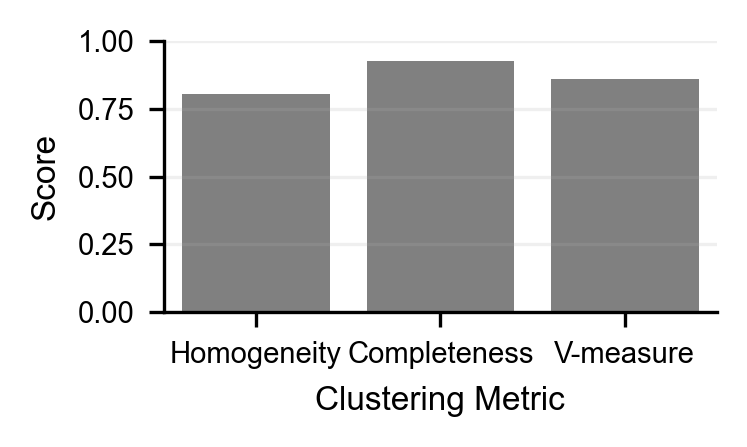

,Clustering Metric,Score
0,Homogeneity,0.806016
1,Completeness,0.924524
2,V-measure,0.861212


In [7]:
cluster_scores = pd.Series(
    homogeneity_completeness_v_measure(mrconso_term_to_syn, tea_term_to_syn), 
    index=["Homogeneity", "Completeness", "V-measure"]
).to_frame("Score").rename_axis("Clustering Metric").reset_index()
plt.figure(figsize=(2.5,1.5), dpi=300)
sns.barplot(data=cluster_scores, x="Clustering Metric", y="Score", color="grey")
plt.grid(axis="y", alpha=0.2)
plt.ylim(0, 1)

plt.savefig("../../figure-panels/SuppFig2a.jpg")
plt.show()
cluster_scores

# LSA on GeneTEA embedding

In [8]:
gene_cos = pd.DataFrame(cosine_similarity(tea.lsa_emb.loc[protein_coding]), index=protein_coding, columns=protein_coding)

In [9]:
lsa_emb = tea.lsa_emb
real_mean, null_mean = {}, {}
rng = np.random.default_rng(27)
for i, real_group in hgnc_groups.items():
    real_mean[i] = tril_stack(gene_cos.loc[real_group, real_group]).mean()
    null_group = protein_coding.sample(len(real_group), random_state=rng.bit_generator)
    null_mean[i] = tril_stack(gene_cos.loc[null_group, null_group]).mean()

In [10]:
in_small_groups = hgnc_groups.loc[lambda x: x.apply(len) < 5].explode().unique()
len(in_small_groups)

1689

/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
<timed exec>:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


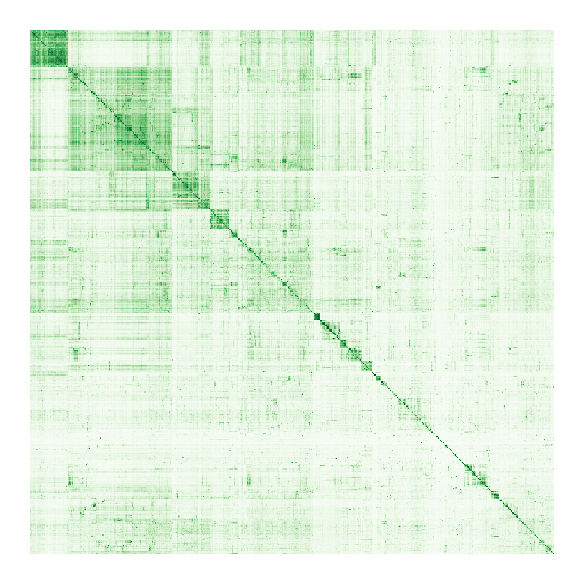

CPU times: user 5.11 s, sys: 113 ms, total: 5.22 s
Wall time: 3 s


In [11]:
%%time
cg = sns.clustermap(
    gene_cos.loc[in_small_groups, in_small_groups], annot=False, cmap="Greens", vmin=0, vmax=1, 
    xticklabels=False, yticklabels=False, figsize=(2.5,2.5)
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.set_xlabel(None)
ax.set_ylabel(None)
cg.cax.set_visible(False)

plt.savefig("../../figure-panels/Fig2a.jpg", bbox_inches="tight")
plt.show()

/var/folders/8g/bm84gl3102v3fy4htn8rpv340000gp/T/ipykernel_47063/4119509897.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../figure-panels/Fig2a_cbar.jpg", bbox_inches='tight')
/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


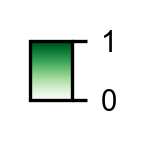

In [12]:
fig = plt.figure(figsize=(0.5, 0.5))
cb = mpl.colorbar.ColorbarBase(plt.gca(), orientation='vertical', 
                               cmap='Greens', ticks=None)
plt.savefig("../../figure-panels/Fig2a_cbar.jpg", bbox_inches='tight')
plt.show()

/var/folders/8g/bm84gl3102v3fy4htn8rpv340000gp/T/ipykernel_47063/2635823527.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../figure-panels/Fig2b.jpg",bbox_inches='tight')
/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


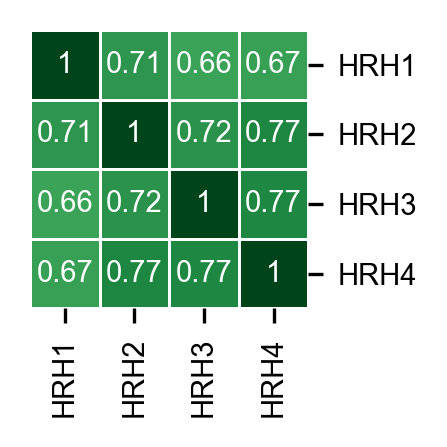

In [13]:
raf_family = hgnc_groups["Histamine receptors"]

plt.figure(figsize=(1.5,1.5), dpi=300)
ax = sns.heatmap(
    gene_cos.loc[raf_family, raf_family], annot=True, cmap="Greens", vmin=0, vmax=1,
    linewidth=0.25, cbar=False
)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(rotation=90)
ax.tick_params(right=True, labelright=True, left=False, labelleft=False)
plt.yticks(rotation=0)
plt.savefig("../../figure-panels/Fig2b.jpg",bbox_inches='tight')
plt.show()

/var/folders/8g/bm84gl3102v3fy4htn8rpv340000gp/T/ipykernel_47063/1598206534.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../figure-panels/Fig2c.jpg",bbox_inches='tight')
/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


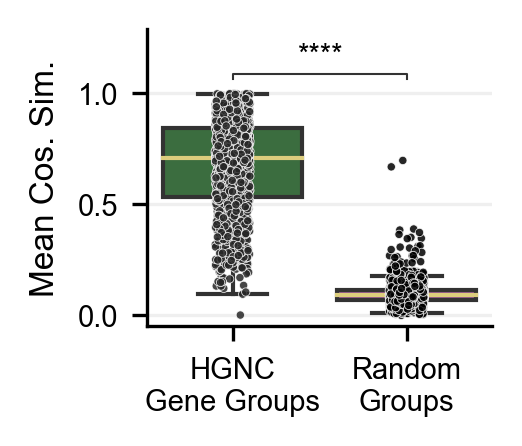

,,statistic,pvalue,df,n HGNC,n Random,str
HGNC\nGene Groups,Random\nGroups,102.511193,0.0,2884.0,1443.0,1443.0,p=0


In [14]:
group_labels = ["HGNC\nGene Groups", "Random\nGroups"]
mean_group_cos = pd.DataFrame([real_mean, null_mean], index=group_labels).T.stack().reset_index()

groups = mean_group_cos.groupby("level_1")[0].apply(list)
cos_pval = scipy.stats.ttest_ind(groups[group_labels[0]], groups[group_labels[1]], alternative="greater")
cos_pval = pd.Series({
    "statistic":cos_pval.statistic, "pvalue":cos_pval.pvalue, "df":cos_pval.df, 
    "n HGNC":len(groups[group_labels[0]]), "n Random":len(groups[group_labels[1]])
}).to_frame(tuple(group_labels)).T
cos_pval["str"] = "p="+cos_pval["pvalue"].apply(scientific_format)

plt.figure(figsize=(1.75,1.5), dpi=300)
distplot(
    data=mean_group_cos, x="level_1", y=0, hue="level_1", order=group_labels,
    hue_order=group_labels, palette=[PALETTE[7], PALETTE[6]], s=2, 
)
pairs = [(i[0], i[1]) for i in cos_pval.index]
annot_wrapper(
    plt.gca(), pairs, cos_pval, data=mean_group_cos, x="level_1", y=0, hue="level_1", 
    order=group_labels, hue_order=group_labels,
)
plt.legend().remove()
plt.xlabel(None)
plt.ylabel("Mean Cos. Sim.")
plt.grid(axis="y", alpha=0.2)

plt.savefig("../../figure-panels/Fig2c.jpg",bbox_inches='tight')
plt.show()
cos_pval

# Gene Set Db Size and Redundancy

In [15]:
enrichr_sets = pd.read_csv(
    FILEPATHS["enrichr_sets"], 
    index_col=None
).set_index(["Set", "Library"])["Genes"].str.split("|")
enrichr_genes = enrichr_sets.explode().str.split("|").str[0]
#map to latest HUGO symbols
remapped_enrichr = gsm.map_genes(enrichr_genes.drop_duplicates())
clean_enrichr_sets = enrichr_sets.apply(lambda x: remapped_enrichr.reindex(x).dropna().to_list())

In [16]:
ggost = read_gmt(FILEPATHS["ggost_sets"])

/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


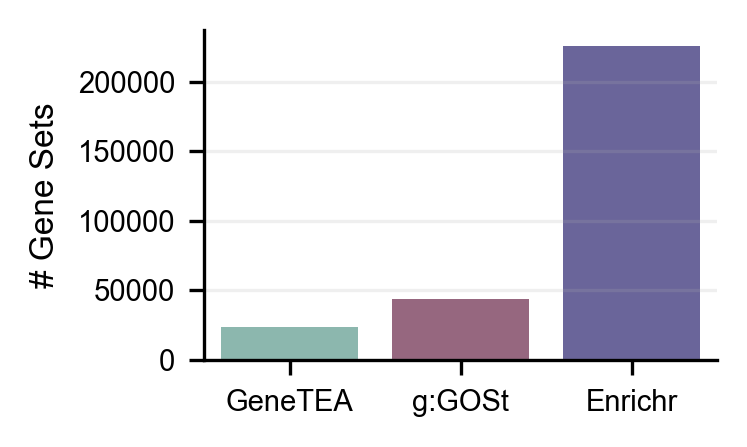

,GeneTEA,g:GOSt,Enrichr
# Gene Sets,23767,43597,225891


In [17]:
sets = {
    "GeneTEA":tea.get_entities_matching_term(None).str.split().apply(set).loc[lambda x:~x.index.isin(tea.stopwords)],
    "g:GOSt":ggost["Genes"].apply(set),
    "Enrichr":clean_enrichr_sets.dropna().apply(set).loc[lambda x: x.apply(len) > 0]
}
library_sizes = pd.DataFrame({k:len(sets[k]) for k in sets.keys()}, index=["# Gene Sets"])
plt.figure(figsize=(2.5,1.5), dpi=300)
sns.barplot(data=library_sizes, order=ORDER, palette=PALETTE, alpha=0.75, errorbar="se")
plt.ylabel("# Gene Sets")
plt.grid(axis="y", alpha=0.2)

plt.savefig("../../figure-panels/SuppFig1b.jpg")
plt.show()
library_sizes

In [18]:
%%time
thresh = 0.5
coeffs, counts = get_overlaps(sets, n=500, reps=10, thresh=thresh)

0
1
2
3
4
5
6
7
8
9
CPU times: user 8min 14s, sys: 2.59 s, total: 8min 17s
Wall time: 8min 17s


/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


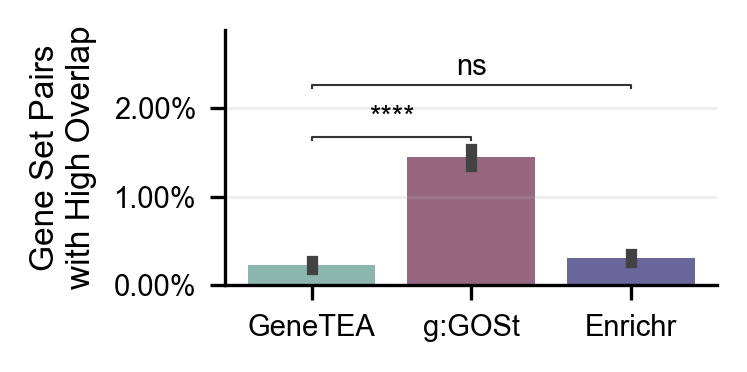

statistic        pvalue    df  n anchor  n other         str
GeneTEA Enrichr  -1.201051  1.226491e-01  18.0      10.0     10.0      p=0.12
        g:GOSt  -11.059624  9.277266e-10  18.0      10.0     10.0  p=9.28e-10

In [19]:
ov_pvals = ttest_on_metric(counts, "percent", alternative="less")
plt.figure(figsize=(2.5,1.25), dpi=300)
ax = sns.barplot(data=counts, x="model", y="percent", order=ORDER, palette=PALETTE, alpha=0.75, errorbar="se")
pairs = [(i[0], i[1]) for i in ov_pvals.index]
annot_wrapper(
    ax, pairs, ov_pvals, data=counts, y="percent", x="model", hue=None, plot="barplot",
    order=ORDER, hue_order=None, is_vertical=False, orient="v",
)
plt.ylabel("Gene Set Pairs\nwith High Overlap")
plt.xlabel(None)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))
plt.grid(axis="y", alpha=0.2)

plt.savefig("../../figure-panels/Fig2d_upper.jpg")
plt.show()
ov_pvals

/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


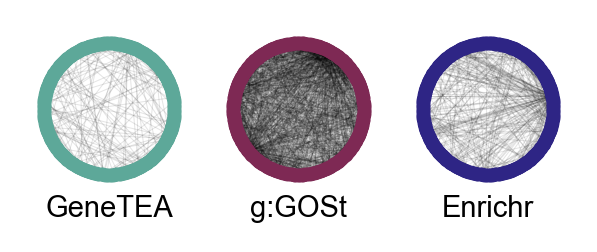

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(2,0.85), dpi=300)
for i, mod in enumerate(ORDER):
    plot_hairball(
        coeffs[0][mod], thresh=thresh, node_kws=dict(node_color=PALETTE[i]), 
        edge_kws=dict(alpha=0.1), ax=axs[i], 
    )
    axs[i].set_title(mod, y=-0.33, fontsize=7)
    axs[i].set_axis_off()
    
plt.savefig("../../figure-panels/Fig2d_lower.jpg")
plt.show()

# Connexin sets example

In [21]:
enrichr_connexin = read_gmt(FILEPATHS["enrichr_connexin"]).loc[lambda x: ~x["Name"].str.contains("Automatic")]

In [22]:
terms = ["~ connexin"]
matches = tea.get_entities_matching_term(terms)
ggost_sets = ggost["Name"].loc[lambda x: x.str.contains(r"\bconnexin", regex=True, case=False)]
gprof_as_df = ggost.loc[ggost_sets.index].explode("Genes")
gprof_as_df["Name"] = "g:GOSt: "+gprof_as_df.index+"-"+gprof_as_df["Name"]
enrichr_as_df = enrichr_connexin.explode("Genes")
enrichr_as_df["Name"] = "Enrichr: "+enrichr_as_df["Name"]+"-"+enrichr_as_df.index
genetea_as_df = matches.str.split().explode().to_frame("Genes")
genetea_as_df["Name"] = "GeneTEA: "+genetea_as_df.index
as_df = pd.concat({
    "GeneTEA":genetea_as_df, 
    "g:GOSt":gprof_as_df.loc[lambda x: ~x["Genes"].str.startswith("ENSG")], 
    "Enrichr":enrichr_as_df
}).reset_index()
_, _, remap = tea.validate_entities(as_df["Genes"])
as_df["Genes"] = as_df["Genes"].replace(remap)
as_df["Present"] = 1
gene_counts = as_df.groupby("Genes")["Present"].sum().rename("Count").reset_index().sort_values(["Count", "Genes"], ascending=[False, True])
gene_counts["GeneIdx"] = np.arange(len(gene_counts))
as_df["GeneIdx"] = as_df["Genes"].replace(gene_counts.set_index("Genes")["GeneIdx"])

/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


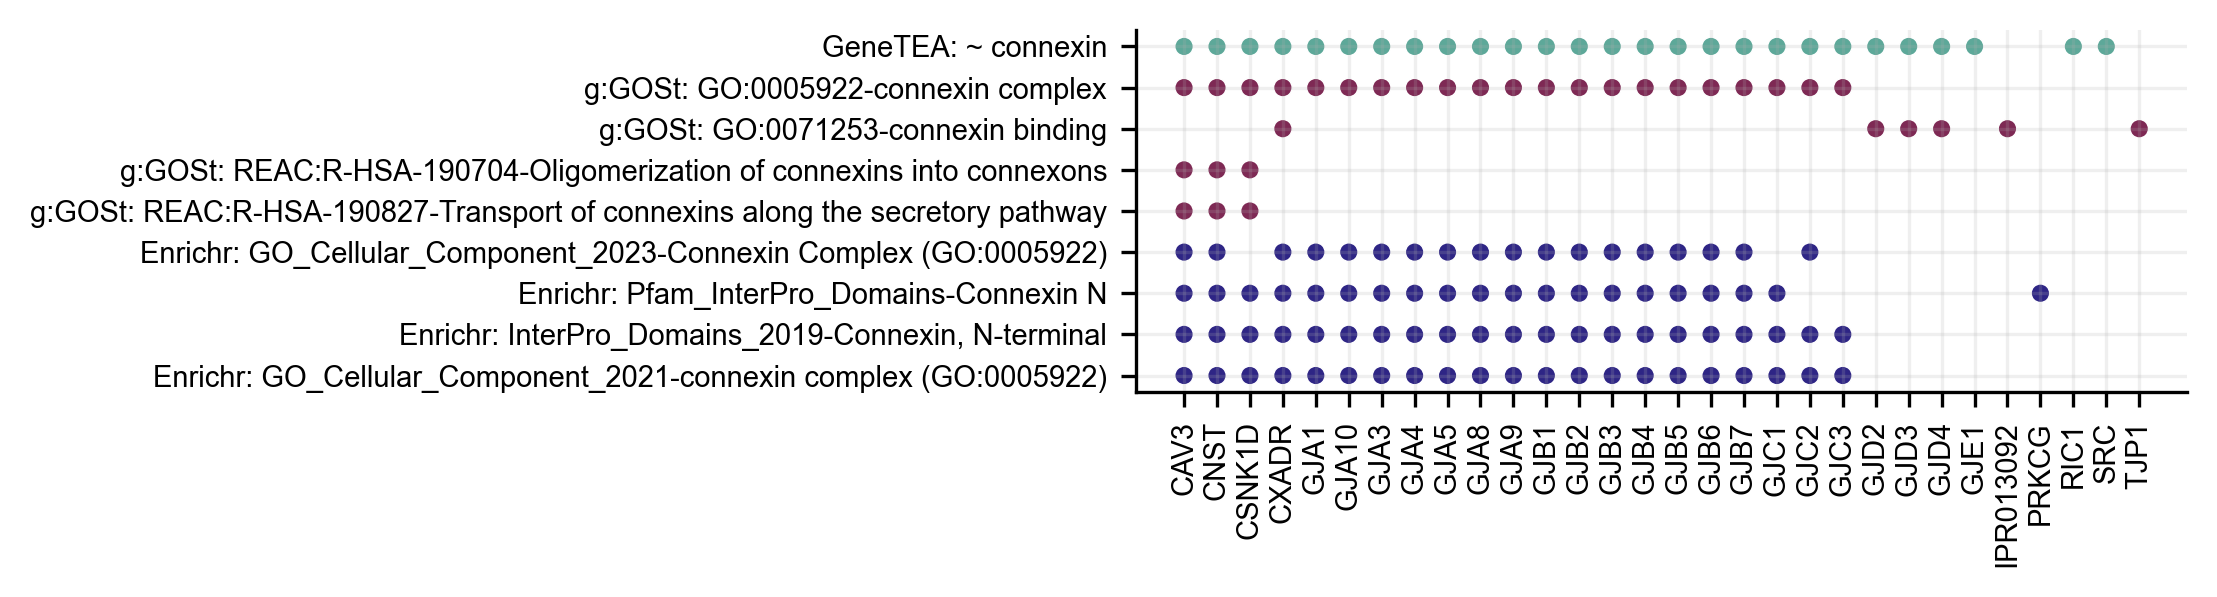

In [23]:
fig = plt.figure(figsize=(7.4,2))
sns.scatterplot(data=as_df, x="GeneIdx", y="Name", hue="level_0", s=20, hue_order=ORDER, palette=PALETTE[:3])
plt.xticks(ticks=gene_counts["Genes"].index, labels=gene_counts["Genes"], rotation=90)
plt.xlabel(None)
plt.ylabel(None)
plt.legend().remove()
plt.grid(True, alpha=0.2)

plt.savefig("../../figure-panels/Fig2e.jpg")
plt.show()